In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input, Flatten


2022-05-05 23:04:15.430517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 23:04:15.430552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filename = "ah78_long.csv"
#filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv("simple_"+filename, index_col=0)
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
ts.describe()


,y,a,b,c,h,yy,dy,A,B,C
count,148688.000000,151764.000000,151764.000000,151764.000000,59382.000000,151764.000000,151763.000000,1.517640e+05,151764.000000,151764.000000
mean,6.450520,5.035761,0.168626,0.653877,67.837966,6.462078,-0.000006,5.035763e+00,0.168602,0.653864
std,1.875935,13.420839,0.494799,4.508887,14.436426,1.886439,0.269697,1.241166e+01,0.063960,1.008095
min,2.164790,0.000000,0.000000,0.000000,40.000000,2.164790,-3.108420,1.154889e-43,0.000000,0.000000
25%,5.106690,0.000000,0.000000,0.000000,59.000000,5.106690,-0.111060,1.429512e-08,0.120520,0.008214
50%,6.161330,0.996000,0.064837,0.000000,65.000000,6.161330,0.000000,1.455194e+00,0.159616,0.201332
75%,7.493510,3.128000,0.115702,0.000000,73.000000,7.549020,0.111020,4.089718e+00,0.206025,0.865938
max,21.758900,192.893043,8.416030,80.000000,201.000000,21.758900,2.109290,1.588831e+02,0.653384,9.797285


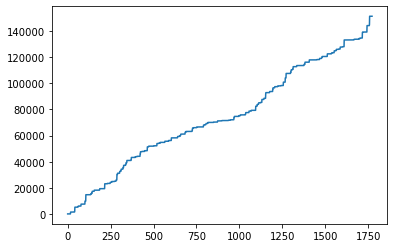

52156

In [3]:
fp_list = [i for i in range(len(ts.fp)) if ts.fp.iloc[i]]

plt.plot(fp_list)
plt.show()

j = np.random.choice(fp_list)
j


In [4]:
N = len(ts)
ts_test = ts.iloc[:N//5]
ts_train = ts.iloc[N//5:]
tau = 6

exogenous = ["a","b","c","A","B","C"]
no_exogen = len(exogenous)

lag = 12

N_train = len(ts_train)
X_train = np.vstack([ts_train["yy"].values[l:N_train-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_train = np.hstack([X_train,ts_train[exogenous].values[:N_train-tau-lag]])
#Y_train = ts_train["yy"].values[lag+tau:]
Y_train = np.vstack([ts_train["yy"].values[lag+t+1:N_train-tau+t+1] for t in range(tau)]).T

#X_test = ts_test[features].iloc[:-tau] 
#Y_test = ts_test["yy"].iloc[tau:]

N_test = len(ts_test)
X_test = np.vstack([ts_test["yy"].values[l:N_test-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_test = np.hstack([X_test,ts_test[exogenous].values[:N_test-tau-lag]])
#Y_test = ts_test["yy"].values[lag+tau:]
Y_test = np.vstack([ts_test["yy"].values[lag+t+1:N_test-tau+t+1] for t in range(tau)]).T

#plt.plot(X_train[:50,:1+lag])
#plt.plot(Y_train[:50], '--')
#plt.show()
#plt.plot(X_test[:50,:1+lag])
#plt.plot(Y_test[:50], '--')
#plt.show()

no_features = no_exogen + 1 + lag

N_train, X_train.shape, Y_train.shape, N_test, X_test.shape, Y_test.shape, no_features


(121412, (121394, 19), (121394, 6), 30352, (30334, 19), (30334, 6), 19)

In [5]:
def mdn_cost(mu_, sigma_, y_):
    #mu_ = Flatten()(mu)
    #sigma_ = Flatten()(sigma)
    #y_ = Flatten()(y)
    dist = tfp.distributions.Normal(loc=mu_, scale=sigma_)
    return tf.reduce_mean(-dist.log_prob(y_))


In [6]:
learning_rate = 0.0003

hidden_width = 30 + tau*2

InputLayer = Input(shape=(no_features,))
#Layer_1 = Dense(12,activation="tanh")(InputLayer)
#Layer_2 = Dense(12,activation="tanh")(Layer_1)
Layer_0 = Dense(hidden_width,activation="relu")(InputLayer)
#Layer_1 = Layer_0
Layer_1 = Dense(hidden_width,activation="relu")(Layer_0)
Layer_2 = Dense(hidden_width,activation="relu")(Layer_1)
mu = Dense(tau, activation="linear")(Layer_2)
sigma = Dense(tau, activation=lambda x: tf.nn.elu(x) + 1.001)(Layer_2)
y_real = Input(shape=(tau,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 42)           840         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 42)           1806        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 42)           1806        ['dense_1[0][0]']                
                                                                                              

2022-05-05 23:04:19.140898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-05 23:04:19.140929: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 23:04:19.140970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-05-05 23:04:19.141162: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
epochs = 500
batch_size = 50

history_cache = model.fit([X_train, Y_train], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((X_test,Y_test))) # the model expects a list of arrays as it has 2 inputs

Final cost: 0.6021


In [8]:
mu_pred.shape, sigma_pred.shape

((30334, 6), (30334, 6))

In [9]:
j = 500
savename = "figs/"+filename.split(".")[0]+"_30_3"
savename


'figs/ah78_long_30_3'

In [22]:
model.save('models/'+filename.split(".")[0]+"_30_3")


2022-05-08 05:30:04.438326: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ah78_long_30_3/assets


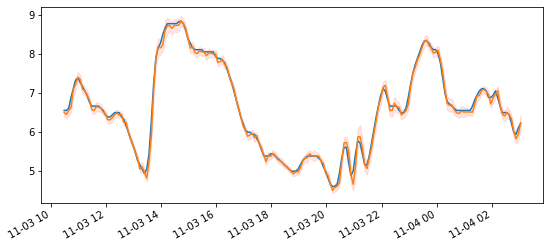

In [10]:
t = 1
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.savefig(savename+"_tau%i.png"%t)

plt.show()

In [ ]:
time_index = ts_test.index[lag+1:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()


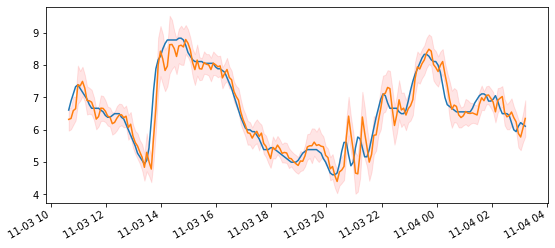

In [14]:
t = 3 # tau
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,t-1]
predicted_sigma = sigma_pred[:,t-1]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()


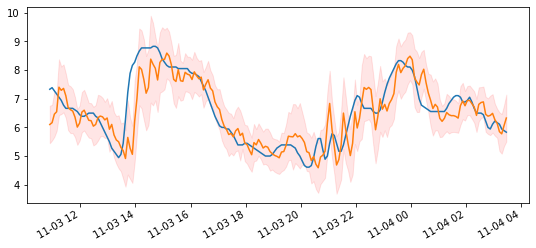

In [12]:
t = tau
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,tau-1]
predicted_sigma = sigma_pred[:,tau-1]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()

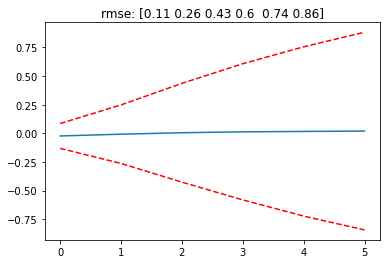

rmse [0.11 0.26 0.43 0.6  0.74 0.86]


In [13]:
err = mu_pred - Y_test
avg = err.mean(axis=0)
std = err.std(axis=0)
plt.plot(avg)
plt.plot(avg+std,'r--')
plt.plot(avg-std,'r--')
plt.title("rmse: "+str(np.round(np.sqrt(avg**2+std**2),2)))
plt.savefig(savename+"_cone.png")
plt.show()

print("rmse", np.round(np.sqrt(avg**2+std**2),2))


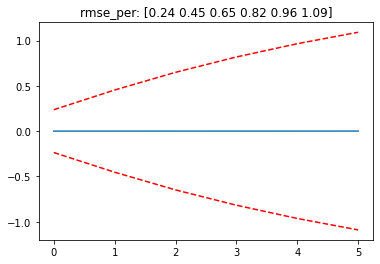

rmse_per [0.11 0.26 0.43 0.6  0.74 0.86]


In [17]:
err_per = Y_test[1:,:] - Y_test[:-1,:1]
avg_per = err_per.mean(axis=0)
std_per = err_per.std(axis=0)
plt.plot(avg_per)
plt.plot(avg_per+std_per,'r--')
plt.plot(avg_per-std_per,'r--')
plt.title("rmse_per: "+str(np.round(np.sqrt(avg_per**2+std_per**2),2)))
plt.savefig(savename+"_cone_per.png")
plt.show()

print("rmse_per", np.round(np.sqrt(avg_per**2+std_per**2),2),np.round(np.sqrt(avg_per**2+std_per**2),2).mean())


In [19]:
print("rmse_per", np.round(np.sqrt(avg**2+std**2),2),np.round(np.sqrt(avg**2+std**2),2).mean())
print("rmse_per", np.round(np.sqrt(avg_per**2+std_per**2),2),np.round(np.sqrt(avg_per**2+std_per**2),2).mean())


rmse_per [0.11 0.26 0.43 0.6  0.74 0.86] 0.49999999999999994
rmse_per [0.24 0.45 0.65 0.82 0.96 1.09] 0.7016666666666667


In [21]:
1-0.5/0.7

0.2857142857142857